## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12608716706578190610
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13850564852548258928
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7300646349226617962
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 144506880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18037139466066493645
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

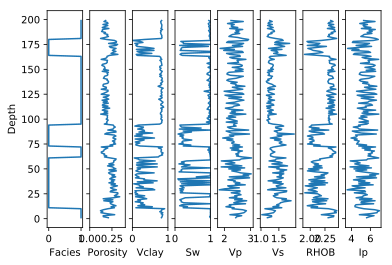

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True)

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


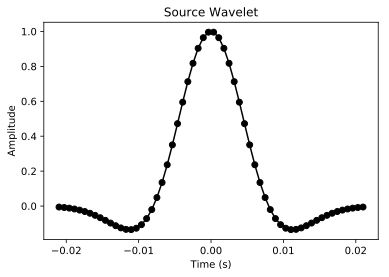

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

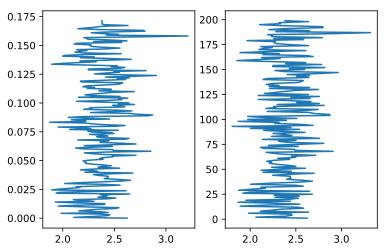

In [8]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


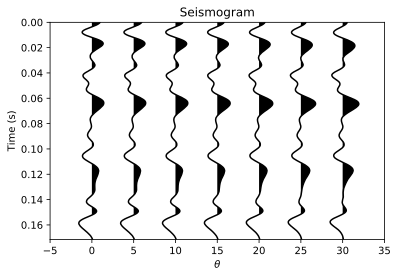

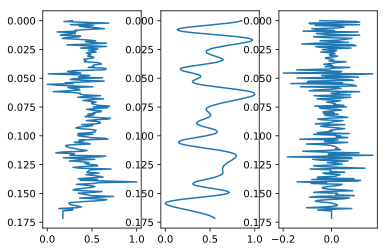

In [9]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [10]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [11]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

# Concatenate Vp, Vs and Density 
num_examples = Vp_time.shape[0]
emodel = np.concatenate((Vp_time,Vs_time,RHOB_time), axis=1)
emodel = emodel.reshape((num_examples, 3, nt))


# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)
# # Normalizing output
# Y_train = normalize(Y_train, axis=2, order=2)
# Y_test = normalize(Y_test, axis=2, order=2)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 7, 246, 1)
Y_train shape: (2000, 3, 246)
X_test shape: (500, 7, 246, 1)
Y_test shape: (500, 3, 246)


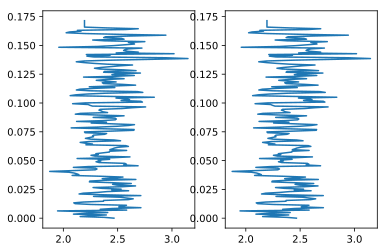

In [12]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

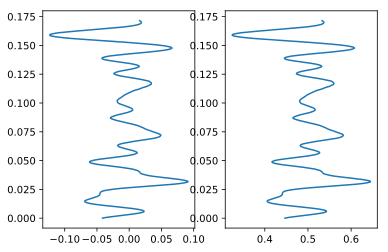

In [13]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [14]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(10, (3, 35), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (3, 35), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(246*3, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((3, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [15]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 212, 10)        1060      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 212, 10)        40        
_________________________________________________________________
activation_1 (Activation)    (None, 5, 212, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 3, 178, 1)         1051      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 3, 178, 1)         4         
_________________________________________________________________
activation_2 (Activation)    (None, 3, 178, 1)         0         
__________

In [17]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [18]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [19]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=32, callbacks=callbacks_list)

# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2403 - val_loss: 0.2094
Epoch 2/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0417 - val_loss: 0.0944
Epoch 3/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0386 - val_loss: 0.1390
Epoch 4/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0430 - val_loss: 0.1911
Epoch 5/1000
1600/1600 [==============================] - 0s 252us/step - loss: 0.0359 - val_loss: 0.5429
Epoch 6/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0427 - val_loss: 0.6069
Epoch 7/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0363 - val_loss: 0.7999
Epoch 8/1000
1600/1600 [==============================] - 0s 257us/step - loss: 0.0377 - val_loss: 0.1180
Epoch 9/1000
1600/1600 [==============================] - 0

1600/1600 [==============================] - 0s 253us/step - loss: 0.0210 - val_loss: 0.0253
Epoch 151/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0207 - val_loss: 0.0321
Epoch 152/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0208 - val_loss: 0.0431
Epoch 153/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0205 - val_loss: 0.0245
Epoch 154/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0206 - val_loss: 0.0261
Epoch 155/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0205 - val_loss: 0.0270
Epoch 156/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0205 - val_loss: 0.0270
Epoch 157/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0204 - val_loss: 0.0307
Epoch 158/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0204 - val_loss: 0.0252
Epoch 159/1000
1600/1600 [=================

Epoch 226/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0179 - val_loss: 0.0246
Epoch 227/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0178 - val_loss: 0.0223
Epoch 228/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0178 - val_loss: 0.0232
Epoch 229/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0178 - val_loss: 0.0225
Epoch 230/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0176 - val_loss: 0.0235
Epoch 231/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0177 - val_loss: 0.0276
Epoch 232/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0176 - val_loss: 0.0250
Epoch 233/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0176 - val_loss: 0.0311
Epoch 234/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0175 - val_loss: 0.0232
Epoch 235/1000
1600/1600 [==

Epoch 302/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0159 - val_loss: 0.0214
Epoch 303/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0159 - val_loss: 0.0217
Epoch 304/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0159 - val_loss: 0.0212
Epoch 305/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0159 - val_loss: 0.0212
Epoch 306/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0159 - val_loss: 0.0217
Epoch 307/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0159 - val_loss: 0.0218
Epoch 308/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0159 - val_loss: 0.0213
Epoch 309/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0159 - val_loss: 0.0214
Epoch 310/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0159 - val_loss: 0.0212
Epoch 311/1000
1600/1600 [==

Epoch 378/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0157 - val_loss: 0.0215
Epoch 379/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0157 - val_loss: 0.0224
Epoch 380/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0157 - val_loss: 0.0213
Epoch 381/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0156 - val_loss: 0.0223
Epoch 382/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0157 - val_loss: 0.0214
Epoch 383/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0156 - val_loss: 0.0220
Epoch 384/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0156 - val_loss: 0.0213
Epoch 385/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0156 - val_loss: 0.0217
Epoch 386/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0156 - val_loss: 0.0217
Epoch 387/1000
1600/1600 [==

Epoch 454/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0154 - val_loss: 0.0213
Epoch 455/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0155 - val_loss: 0.0213
Epoch 456/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0154 - val_loss: 0.0214
Epoch 457/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0154 - val_loss: 0.0231
Epoch 458/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0155 - val_loss: 0.0213
Epoch 459/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0154 - val_loss: 0.0214
Epoch 460/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0154 - val_loss: 0.0215
Epoch 461/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0154 - val_loss: 0.0223
Epoch 462/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0154 - val_loss: 0.0213
Epoch 463/1000
1600/1600 [==

Epoch 530/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0212
Epoch 531/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 532/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0214
Epoch 533/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0212
Epoch 534/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0212
Epoch 535/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0214
Epoch 536/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 537/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 538/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 539/1000
1600/1600 [==

Epoch 606/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0151 - val_loss: 0.0212
Epoch 607/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0215
Epoch 608/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 609/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 610/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 611/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 612/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 613/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0214
Epoch 614/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 615/1000
1600/1600 [==

Epoch 682/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 683/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0151 - val_loss: 0.0214
Epoch 684/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 685/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0151 - val_loss: 0.0215
Epoch 686/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 687/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 688/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0212
Epoch 689/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0151 - val_loss: 0.0213
Epoch 690/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0151 - val_loss: 0.0214
Epoch 691/1000
1600/1600 [==

Epoch 758/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 759/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 760/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 761/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 762/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 763/1000
1600/1600 [==============================] - 0s 256us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 764/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 765/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 766/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 767/1000
1600/1600 [==

Epoch 834/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 835/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 836/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 837/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 838/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 839/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 840/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 841/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 842/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 843/1000
1600/1600 [==

Epoch 910/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 911/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 912/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 913/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 914/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 915/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 916/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 917/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 918/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 919/1000
1600/1600 [==

Epoch 986/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 987/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 988/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 989/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 990/1000
1600/1600 [==============================] - 0s 255us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 991/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 992/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 993/1000
1600/1600 [==============================] - 0s 253us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 994/1000
1600/1600 [==============================] - 0s 254us/step - loss: 0.0150 - val_loss: 0.0213
Epoch 995/1000
1600/1600 [==

In [20]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 158us/step

Loss = 0.021166019320487978


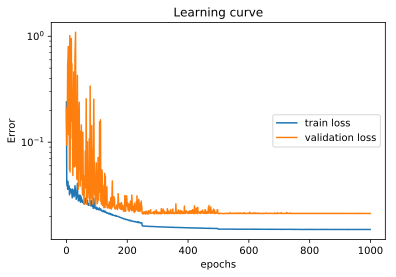

In [21]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [23]:
# Save trained model 
# serialize model to JSON
model_json = ElasticModel.to_json()
with open("elastic_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticModel.save_weights("ElasticModel.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# Load saved model
# load json and create model
json_file = open('elastic_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


ElasticModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

Loaded model from disk


In [22]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

In [23]:
# Use predicted Vp, Vs and RHOB from network
# Concatenate Vp, Vs and Density 

num_examples = Vp_time.shape[0]
emodel_true = np.concatenate((Vp_time,Vs_time,RHOB_time), axis=1)
emodel_true = emodel.reshape((num_examples, 3, nt))

emodel = ElasticModel.predict(np.expand_dims(seis_reshaped_normalized, axis=3))


# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]
petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
petromodel = petromodel.reshape((num_examples, 3, ndepth))

# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(emodel, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Split data into train and test set - elastic model
X_train_true, X_test_true, Y_train_true, Y_test_true = sklearn.model_selection.train_test_split(emodel_true, 
                                                                            petromodel, test_size=0.2, random_state=1)

# # Normalizing output
# Y_train = normalize(Y_train, axis=2, order=2)
# Y_test = normalize(Y_test, axis=2, order=2)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 3, 246, 1)
Y_train shape: (2000, 3, 199)
X_test shape: (500, 3, 246, 1)
Y_test shape: (500, 3, 199)


In [24]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elastic_petronet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (1, 20), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 20), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*3, name='fc1')(X)
    X = Activation('sigmoid')(X)
    
    X = Reshape((3, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticPetroModel')

    return model
    ### END CODE HERE ###

In [25]:
# Create the model
ElasticPetroModel = elastic_petronet(X_train.shape[1:])

In [26]:
# Summary and plot of the model

ElasticPetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 3, 227, 60)        1260      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 3, 227, 60)        240       
_________________________________________________________________
activation_4 (Activation)    (None, 3, 227, 60)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 2, 226, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 207, 1)         1201      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 207, 1)         4         
__________

In [27]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [28]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [29]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = ElasticPetroModel.fit(X_train, Y_train, validation_split=0.2, epochs=250, batch_size=32, callbacks=callbacks_list)

# history = ElasticPetroModel.fit(X_train, Y_train, validation_split=0.2, epochs=250, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/250
1600/1600 [==============================] - 1s 695us/step - loss: 0.0778 - val_loss: 0.1317
Epoch 2/250
1600/1600 [==============================] - 0s 264us/step - loss: 0.0573 - val_loss: 0.0591
Epoch 3/250
1600/1600 [==============================] - 0s 255us/step - loss: 0.0495 - val_loss: 0.1149
Epoch 4/250
1600/1600 [==============================] - 0s 245us/step - loss: 0.0461 - val_loss: 0.1198
Epoch 5/250
1600/1600 [==============================] - 0s 247us/step - loss: 0.0443 - val_loss: 0.1195
Epoch 6/250
1600/1600 [==============================] - 0s 243us/step - loss: 0.0433 - val_loss: 0.1181
Epoch 7/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0425 - val_loss: 0.1147
Epoch 8/250
1600/1600 [==============================] - 0s 241us/step - loss: 0.0421 - val_loss: 0.1031
Epoch 9/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0416 - val_loss: 0.0926
Epoch 10

Epoch 78/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0358 - val_loss: 0.0439
Epoch 79/250
1600/1600 [==============================] - 0s 239us/step - loss: 0.0357 - val_loss: 0.0444
Epoch 80/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0357 - val_loss: 0.0440
Epoch 81/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0357 - val_loss: 0.0440
Epoch 82/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0357 - val_loss: 0.0447
Epoch 83/250
1600/1600 [==============================] - 0s 247us/step - loss: 0.0357 - val_loss: 0.0450
Epoch 84/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0357 - val_loss: 0.0445
Epoch 85/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0357 - val_loss: 0.0442
Epoch 86/250
1600/1600 [==============================] - 0s 239us/step - loss: 0.0356 - val_loss: 0.0444
Epoch 87/250
1600/1600 [======================

Epoch 155/250
1600/1600 [==============================] - 0s 239us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 156/250
1600/1600 [==============================] - 0s 239us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 157/250
1600/1600 [==============================] - 0s 239us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 158/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 159/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 160/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 161/250
1600/1600 [==============================] - 0s 239us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 162/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0354 - val_loss: 0.0441
Epoch 163/250
1600/1600 [==============================] - 0s 240us/step - loss: 0.0353 - val_loss: 0.0441
Epoch 164/250
1600/1600 [============

In [30]:
# Testing and evaluating the model
preds = ElasticPetroModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 104us/step

Loss = 0.04428737500309944


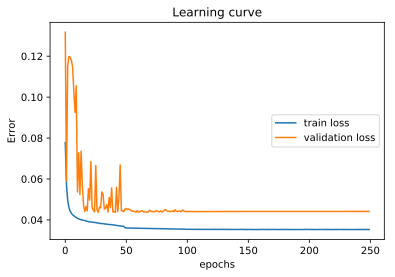

In [31]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [ ]:
# Save trained model 
# serialize model to JSON
model_json = ElasticPetroModel.to_json()
with open("elastic_petromodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticPetroModel.save_weights("ElasticPetroModel.h5")
print("Saved model to disk")

In [ ]:
# Load saved model
# load json and create model
json_file = open('elastic_petromodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ElasticPetroModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticPetroModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

In [32]:
# Predict training and test data using the trained network
test_output = ElasticPetroModel.predict(X_test)
train_output = ElasticPetroModel.predict(X_train)

In [23]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output - Y_train)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output - Y_test)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.07033371 0.08356265 0.04242024]
Test error =  [0.08013145 0.09629283 0.04863137]


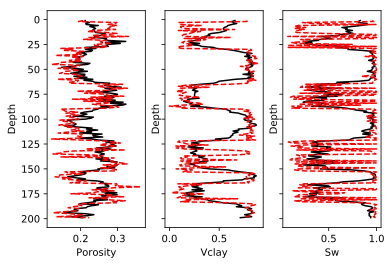

In [33]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(train_output[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_train[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

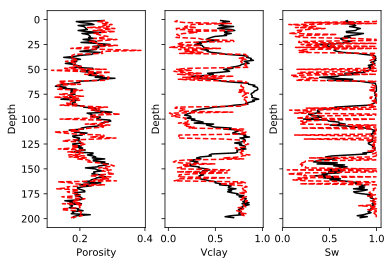

In [33]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(test_output[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_test[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [65]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output.shape[0])
Vclay_corr_train = np.zeros(train_output.shape[0])
Sw_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
    Sw_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output.shape[0])
Vclay_corr_test = np.zeros(test_output.shape[0])
Sw_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
    Sw_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))

Average correlation in porosity for training data =  0.609188798112524
Average correlation in Vclay for training data =  0.7426036798592693
Average correlation in Sw for training data =  0.6731594441631849
Average correlation in porosity for training data =  0.508585299070811
Average correlation in Vclay for training data =  0.663296914092691
Average correlation in Sw for training data =  0.5797078907126716


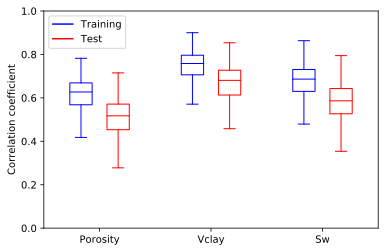

In [74]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
setBoxColors(bp)

# set axes limits and labels
xlim(0,9)
ylim(0,1)
ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticks([1.5, 4.5, 7.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'))
hB.set_visible(False)
hR.set_visible(False)



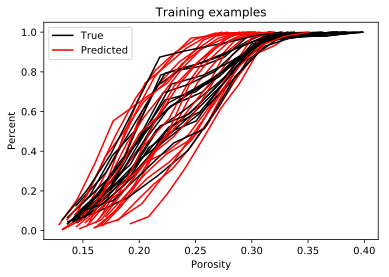

In [84]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
#     plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Training examples')

plt.legend(['True', 'Predicted'])




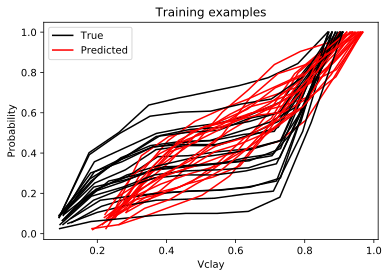

In [86]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Training examples')
    
plt.legend(['True', 'Predicted'])

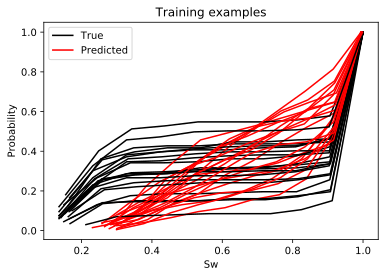

In [88]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Training examples')
plt.legend(['True', 'Predicted'])

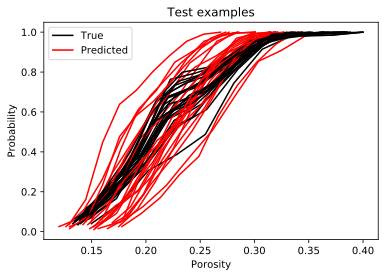

In [94]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Test examples')
plt.legend(['True', 'Predicted'])    

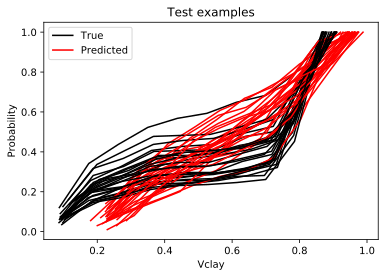

In [95]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

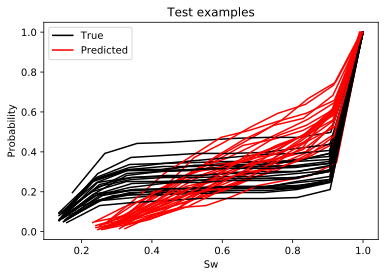

In [96]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

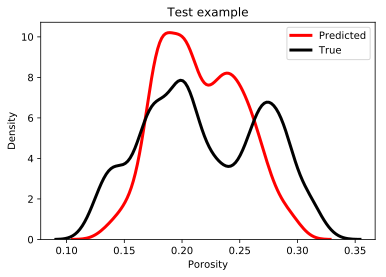

In [36]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 12
sns.kdeplot(test_output[sample_number,0,:],  
             color='red', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output[sample_number,0,:]), np.max(test_output[sample_number,0,:])))
sns.kdeplot(Y_test[sample_number,0,:],  
             color='black', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test[sample_number,0,:]), np.max(Y_test[sample_number,0,:])))
plt.xlabel('Porosity')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

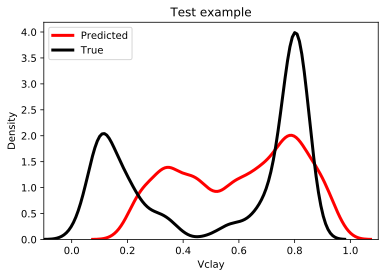

In [38]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 12

sns.kdeplot(test_output[sample_number,1,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,1,:]), np.max(test_output[sample_number,1,:])))
sns.kdeplot(Y_test[sample_number,1,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,1,:]), np.max(Y_test[sample_number,1,:])))
plt.xlabel('Vclay')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

(-0.1, 1.1)

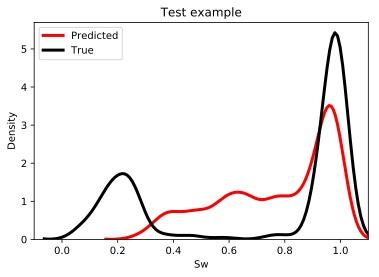

In [39]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,2,:]), np.max(test_output[sample_number,2,:])))
sns.kdeplot(Y_test[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,2,:]), np.max(Y_test[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

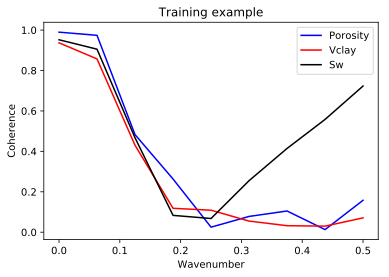

In [36]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")


plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

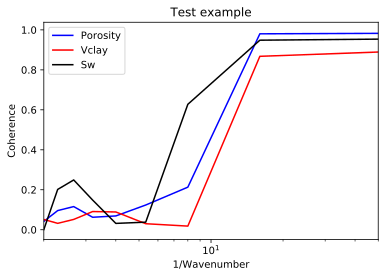

In [38]:
# Spectral coherence between true and predicted 

sample_number = 12
Cxy_poro, wavenumber_poro = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
Cxy_sw, wavenumber_sw = plt.cohere(Y_test[sample_number,2,:], test_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(50,2)
plt.gca().invert_xaxis()
plt.xscale("log")

plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)